# READ DATA from ECG and MMV

In [16]:
import os
import numpy as np
import pandas as pd
from typing import Tuple


FS_FALLBACK = 250.0                     # 若無時間欄，使用此取樣率

def load_ecg_csv(path: str) -> Tuple[pd.DataFrame, float, str]:
    """
    回傳: (df 只含 ['t_sec','wave'], fs_Hz, info)
    規則:
      - 若有 time/t/timestamp/sec/ms 等欄，嘗試判斷單位並換算成秒
      - 若沒有時間欄，用 FS_FALLBACK 與樣本索引建立時間
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f'File not found: {path}')
    df0 = pd.read_csv(path)
    if df0.empty:
        raise ValueError('Empty CSV.')

    cols = [c.lower().strip() for c in df0.columns]
    df0.columns = cols
    info = []

    # 嘗試找到時間欄
    t_col = next((c for c in ['t','time','timestamp','time_s','sec','seconds','ms','millisecond','milliseconds']
                  if c in df0.columns), None)

    if t_col is not None:
        t = pd.to_numeric(df0[t_col], errors='coerce').astype(float).values
        if len(t) < 2:
            raise ValueError('Time column too short to infer fs.')
        dt = np.diff(t)
        dt_med = float(np.nanmedian(dt))

        # 判斷秒或毫秒或索引
        if dt_med > 2:
            # 可能是樣本索引
            if (t % 1 == 0).mean() > 0.95:
                info.append('time looks like sample indices; using FS_FALLBACK')
                fs = float(FS_FALLBACK)
                t_sec = np.arange(len(t)) / fs
            else:
                info.append('time treated as seconds')
                t_sec = t
                fs = float(1.0 / np.nanmedian(np.diff(t_sec)))
        elif dt_med > 0.02:
            info.append('time treated as seconds')
            t_sec = t
            fs = float(1.0 / np.nanmedian(np.diff(t_sec)))
        else:
            # 可能是毫秒
            if dt_med < 0.002:
                info.append('time treated as seconds')
                t_sec = t
                fs = float(1.0 / np.nanmedian(np.diff(t_sec)))
            else:
                info.append('time treated as milliseconds; converted to seconds')
                t_sec = t 
                fs = float(1.0 / np.nanmedian(np.diff(t_sec)))

        # 選 ECG 欄
        ecg_col = next((c for c in ['ecg','ecg_mv','lead1','lead_i','v1','value','signal']
                        if c in df0.columns and c != t_col), None)
        if ecg_col is None:
            # 取第一個非時間欄
            rest = [c for c in df0.columns if c != t_col]
            if not rest:
                raise ValueError('No ECG column found.')
            ecg_col = rest[0]
        ecg = pd.to_numeric(df0[ecg_col], errors='coerce').astype(float).values
    else:
        info.append('no time column; using FS_FALLBACK and sample index')
        fs = float(FS_FALLBACK)
        first_col = df0.columns[0]
        ecg = pd.to_numeric(df0[first_col], errors='coerce').astype(float).values
        t_sec = np.arange(len(ecg)) / fs

    df = pd.DataFrame({'t_sec': t_sec, 'wave': ecg})
    return df, fs, '; '.join(info) if info else 'inferred automatically'


def normalize_ts(df: pd.DataFrame,
                 y_candidates=('ecg','mmv','mmwave','heartbeat','value','signal'),
                 dt: float|None=None,
                 amp_method: str='absmax',  # 'absmax' or 'minmax'
                 eps: float=1e-12) -> pd.DataFrame:
    # 找 y 欄
    cols_lower = {c.lower(): c for c in df.columns}
    ycol = next((cols_lower[c] for c in cols_lower if c in y_candidates), None)
    if ycol is None:
        raise KeyError(f"找不到訊號欄。可用候選：{y_candidates}；現有欄位：{list(df.columns)}")

    out = df.copy()

    # 確保 t_sec
    if 't_sec' not in out.columns:
        if dt is None:
            raise KeyError("缺少 't_sec' 且未提供 dt。請給 dt，例如 0.1")
        out.insert(0, 't_sec', np.arange(len(out))*dt)

    # 只保留 t_sec + y 並統一命名
    out = out[['t_sec', ycol]].rename(columns={ycol: 'wave'}).copy()

    # 幅度歸一到 [-1, 1]
    x = out['wave'].astype(float).to_numpy()
    if amp_method == 'absmax':
        # 保零點，適合雙極性（ECG）
        s = np.nanmax(np.abs(x))
        s = s if s > eps else 1.0
        x_norm = x / s
    elif amp_method == 'minmax':
        # 線性映射到 [-1, 1]
        x_min, x_max = np.nanmin(x), np.nanmax(x)
        if x_max - x_min < eps:
            x_norm = np.zeros_like(x)
        else:
            x_norm = 2.0 * (x - x_min) / (x_max - x_min) - 1.0
    else:
        raise ValueError("amp_method must be 'absmax' or 'minmax'.")

    out['wave'] = np.clip(x_norm, -1.0, 1.0)
    return out
def pltot_fixed(df, title='Signal', label='sig'):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,4))
    plt.plot(df['t_sec'], df['wave'], label=label)
    plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.title(title)
    plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

def combine_plots(df1, df2, title='Combined Signals', label1='sig1', label2='sig2'):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,4))
    plt.plot(df1['t_sec'], df1['wave'], label=label1)
    plt.plot(df2['t_sec'], df2['wave'], label=label2)
    plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.title(title)
    plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

In [17]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Unified mmWave vitals merger using load_frames(paths).
- Keeps the file-reading style from the second snippet (load_frames).
- Extracts per-frame vitals.heartWaveform and merges across files.
- Produces stats and a plot.

Usage:
    python mmwave_heart_merge.py /path/to/folder [-o outputs]

In notebooks:
    from mmwave_heart_merge import process_vitals_folder
    summary = process_vitals_folder("data", outdir="outputs")
"""
import os
import re
import glob
import json
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# -----------------------------
# I/O helpers
# -----------------------------

def natural_sort_key(filename):
    """自然排序：replay_1, replay_2, ..., replay_10"""
    numbers = re.findall(r'\d+', filename)
    return int(numbers[0]) if numbers else 0

def find_replay_jsons(folder):
    """Find replay_*.json under folder, natural-sorted."""
    pattern = os.path.join(folder, "replay_*.json")
    files = glob.glob(pattern)
    files.sort(key=lambda x: natural_sort_key(os.path.basename(x)))
    return files

# -----------------------------
# Core loader following the "load_frames(paths)" pattern
# -----------------------------

def load_frames(paths):
    """
    Load and parse JSON frame data from multiple files.
    Returns a pandas DataFrame sorted by timestamp.
    Columns:
        source, frame, timestamp_ms,
        heartWaveform, heartRate, breathRate, rangeBin, breathDeviation,
        numTracks, numPoints
    """
    rows = []
    for p in paths:
        if not os.path.exists(p):
            print(f"[warn] file not found: {p}")
            continue
        with open(p, "r", encoding="utf-8") as f:
            root = json.load(f)

        for entry in root.get("data", []):
            fd = entry.get("frameData", {}) or {}
            ts = entry.get("timestamp", None)  # ms
            frame_num = fd.get("frameNum", None)

            vit = fd.get("vitals", None) or {}
            hw = vit.get("heartWaveform", None)
            hr = vit.get("heartRate", None)
            br = vit.get("breathRate", None)
            rb = vit.get("rangeBin", None)
            bd = vit.get("breathDeviation", None)

            rows.append({
                "source": os.path.basename(p),
                "frame": frame_num,
                "timestamp_ms": ts,
                "numTracks": fd.get("numDetectedTracks", None),
                "numPoints": fd.get("numDetectedPoints", None),
                "heartWaveform": hw if isinstance(hw, list) else None,
                "heartRate": hr,
                "breathRate": br,
                "rangeBin": rb,
                "breathDeviation": bd,
            })

    df = pd.DataFrame(rows).dropna(subset=["timestamp_ms"])
    df = df.sort_values(["timestamp_ms", "source", "frame"], kind="mergesort").reset_index(drop=True)
    return df

# -----------------------------
# Processing and plotting
# -----------------------------

def merge_heart_waveforms(df):
    """
    Merge all available heartWaveform arrays in time order.
    Returns:
        wave (np.ndarray), segments (list of dict per source file)
    """
    all_wave = []
    segments = []  # per-file segment boundaries for plotting and stats

    # record cumulative offset when each file starts
    cur_offset = 0
    for src, sub in df.groupby("source", sort=False):
        file_points = 0
        frames_info = []
        for _, row in sub.iterrows():
            wf = row.get("heartWaveform", None)
            if isinstance(wf, list) and len(wf) > 0:
                start = cur_offset + file_points
                all_wave.extend(wf)
                end = cur_offset + file_points + len(wf)
                frames_info.append({
                    "frameNum": int(row["frame"]) if pd.notna(row["frame"]) else None,
                    "timestamp": float(row["timestamp_ms"]),
                    "heartRate": float(row["heartRate"]) if pd.notna(row["heartRate"]) else None,
                    "waveformLength": int(len(wf)),
                    "startIndex": int(start),
                    "endIndex": int(end)
                })
                file_points += len(wf)

        segments.append({
            "filename": src,
            "totalPoints": int(file_points),
            "frameCount": int(len(frames_info)),
            "startIndex": int(cur_offset),
            "endIndex": int(cur_offset + file_points),
            "frame_info": frames_info
        })
        cur_offset += file_points

    return np.asarray(all_wave, dtype=float), segments

def print_statistics(wave, segments, df_meta=None):
    """Print summary statistics and per-file info."""
    if wave.size == 0:
        print("[warn] No heartWaveform data found.")
        return

    print("\n" + "="*60)
    print("統計資訊")
    print("="*60)
    print(f"總資料點數: {len(wave)}")
    print(f"最大振幅: {np.max(wave):.4f}")
    print(f"最小振幅: {np.min(wave):.4f}")
    print(f"平均振幅: {np.mean(wave):.4f}")
    print(f"標準差: {np.std(wave):.4f}\n")

    print("檔案詳情:")
    print("-"*60)
    for seg in segments:
        print(f"\n檔案: {seg['filename']}")
        print(f"  資料點: {seg['totalPoints']}")
        print(f"  Frame數: {seg['frameCount']}")
        print(f"  索引範圍: [{seg['startIndex']}, {seg['endIndex']})")

        hrs = [fi["heartRate"] for fi in seg["frame_info"] if fi["heartRate"] is not None and fi["heartRate"] > 0]
        if hrs:
            print(f"  平均心率: {np.mean(hrs):.2f} bpm")
            print(f"  心率範圍: {np.min(hrs):.2f} - {np.max(hrs):.2f} bpm")

def plot_heart_waveform(wave, segments, save_path=None):
    """
    Plot the merged heart waveform and per-file counts.
    Conforms to the one-chart-per-figure guidance when called separately.
    """
    if wave.size == 0:
        return

    # Primary waveform
    plt.figure(figsize=(16, 5))
    t = np.arange(len(wave))

    plt.plot(t, wave, linewidth=0.8, alpha=0.9)
    plt.xlabel("Sample index")
    plt.ylabel("Amplitude")
    plt.title("Merged heart waveform")
    plt.grid(True, alpha=0.3)

    # Mark file boundaries
    ymax = np.max(wave) if wave.size else 1.0
    for seg in segments:
        x = seg["startIndex"]
        plt.axvline(x=x, linestyle="--", alpha=0.4, linewidth=1.0)
        plt.text(x, ymax, seg["filename"], rotation=90, va="top", fontsize=8)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

# -----------------------------
# High-level API
# -----------------------------

def process_vitals_folder(folder_path, outdir="outputs", fs_hint=10.0):
    """
    Find and load replay_*.json, merge vitals.heartWaveform, print stats, and plot.
    Returns:
        {
            "waveforms": np.ndarray,
            "segments": list[dict],
            "csv": path,
            "plot": path
        }
    """
    files = find_replay_jsons(folder_path)
    if not files:
        print(f"[error] No replay_*.json files found in: {folder_path}")
        return None

    print(f"Found {len(files)} files:")
    for f in files:
        print("  -", os.path.basename(f))
    print()

    df = load_frames(files)
    if df.empty:
        print("[error] No frames with timestamps found.")
        return None

    wave, segments = merge_heart_waveforms(df)
    if wave.size == 0:
        print("[error] No heartWaveform data found in frames.")
        return None

    # Outputs
    os.makedirs(outdir, exist_ok=True)

    # time axis assuming approx constant sampling fs_hint
    fs = float(fs_hint)
    t_uni = np.arange(len(wave), dtype=float) / fs if len(wave) > 0 else np.array([], dtype=float)

    # CSV with t_sec and heartbeat
    csv_path = os.path.join(outdir, "heart_rate_series.csv")
    result_df = pd.DataFrame({
        "t_sec": t_uni,
        "heartbeat": wave.astype(float)
    })
    result_df.to_csv(csv_path, index=False)

    # Plot and save as heartbeat.png
    heart_png = os.path.join(outdir, "heartbeat.png")
    print_statistics(wave, segments, df_meta=df)
    plot_heart_waveform(wave, segments, save_path=heart_png)

    # Summary with the exact required structure
    summary = {
        "samples": int(len(t_uni)),
        "duration_s": float(t_uni[-1] - t_uni[0]) if len(t_uni) > 1 else 0.0,
        "fs_Hz": float(fs),
        "est_hr_bpm": None,
        "csv": csv_path,
        "heartbeat_png": heart_png,
        "dataframe": result_df,
    }
    return summary

# -----------------------------
# CLI
# -----------------------------

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("folder", help="Folder containing replay_*.json")
    ap.add_argument("-o", "--outdir", default="outputs", help="Output directory")
    args = ap.parse_args()

    summary = process_vitals_folder(args.folder, outdir=args.outdir)
    if summary is None:
        raise SystemExit(1)


def transform_to_dataframe(summary):
    y= summary['dataframe']['heartbeat'].values
    dt=0.1
    t=np.arange(len(y))*dt
    df=pd.DataFrame({'t_sec':t,'mmv':y})
    return df

    


Found 3 files:
  - replay_1.json
  - replay_2.json
  - replay_3.json


統計資訊
總資料點數: 270
最大振幅: 1.0121
最小振幅: -1.1056
平均振幅: 0.0043
標準差: 0.3822

檔案詳情:
------------------------------------------------------------

檔案: replay_1.json
  資料點: 90
  Frame數: 6
  索引範圍: [0, 90)
  平均心率: 63.89 bpm
  心率範圍: 50.22 - 75.33 bpm

檔案: replay_2.json
  資料點: 90
  Frame數: 6
  索引範圍: [90, 180)
  平均心率: 61.10 bpm
  心率範圍: 50.22 - 71.99 bpm

檔案: replay_3.json
  資料點: 90
  Frame數: 6
  索引範圍: [180, 270)
  平均心率: 61.94 bpm
  心率範圍: 56.92 - 66.96 bpm


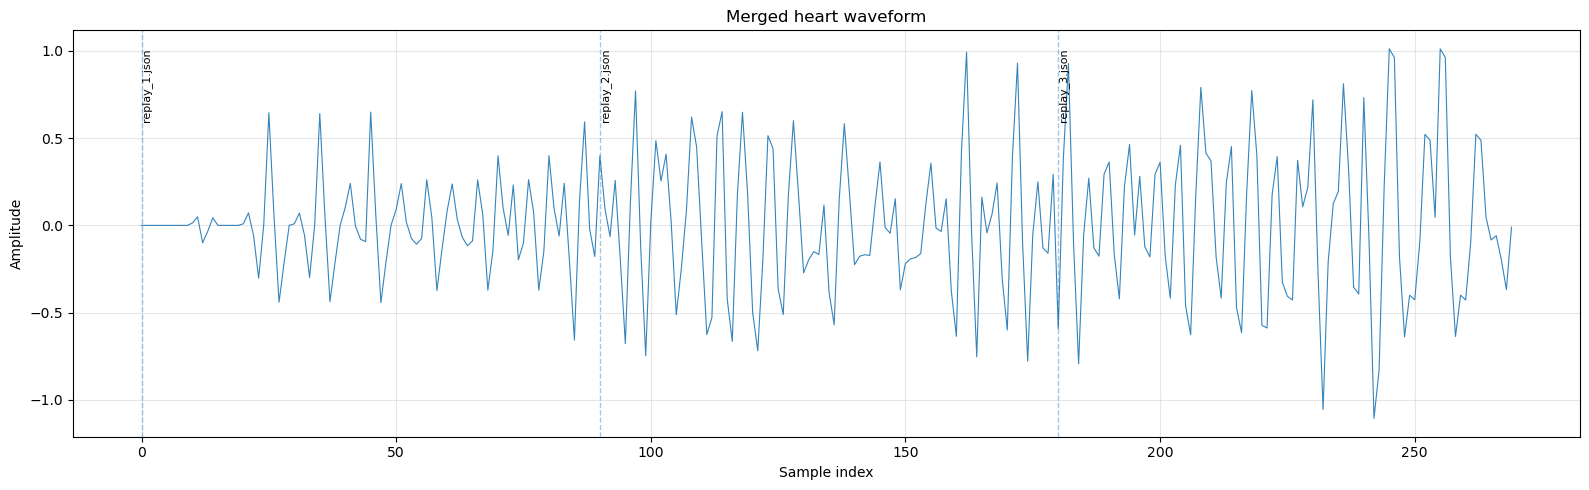

In [18]:
if __name__ == "__main__":
    import os
    cwd = os.getcwd()
    df_ecg, fs_Hz, info = load_ecg_csv(os.path.join(cwd, 'data', 'sample_0','1_1lead.csv')) #read ecg
    summary = process_vitals_folder(cwd+'/data/sample_0', outdir="outputs") # read mmv floder
    df_mmv= transform_to_dataframe(summary) 


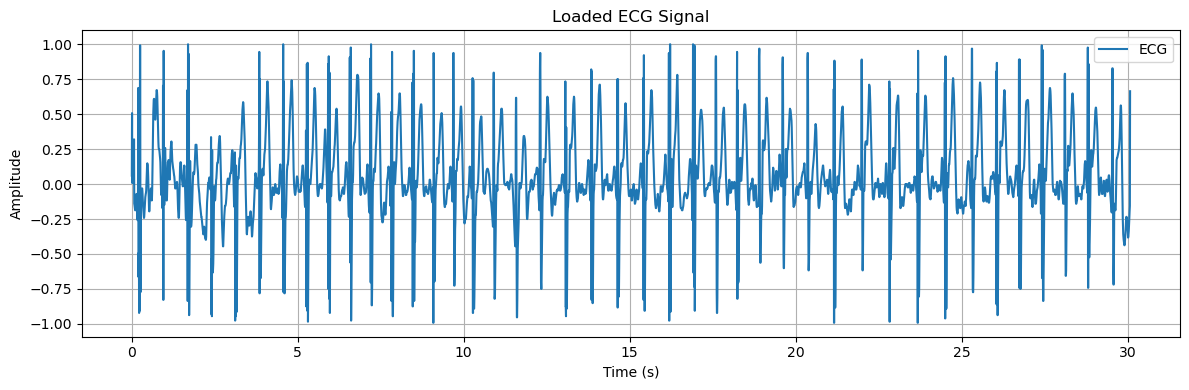

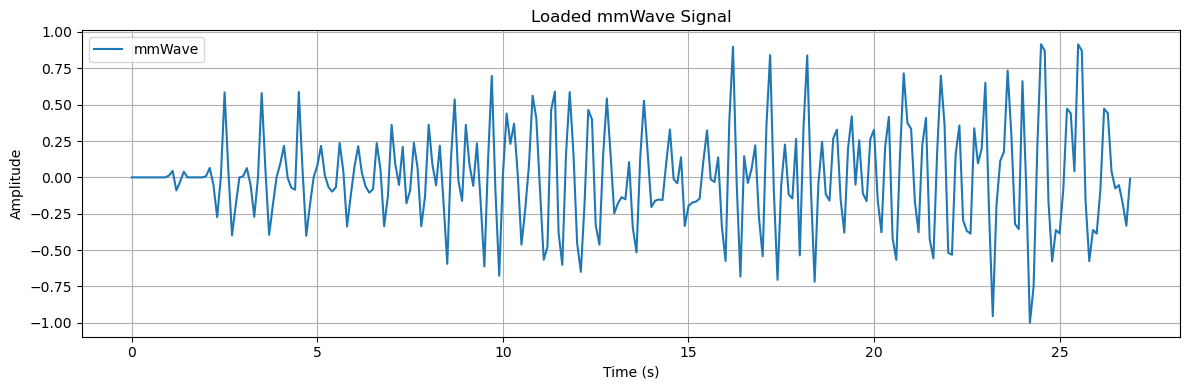

In [19]:
df_ecg_fixed = normalize_ts(df_ecg, y_candidates=('wave',), dt=None)
pltot_fixed(df_ecg_fixed, title='Loaded ECG Signal', label='ECG')
df_mmv_fixed = normalize_ts(df_mmv, y_candidates=('mmv','mmwave','heartbeat','value','signal'), dt=0.1)
pltot_fixed(df_mmv_fixed, title='Loaded mmWave Signal', label='mmWave')

# 濾波

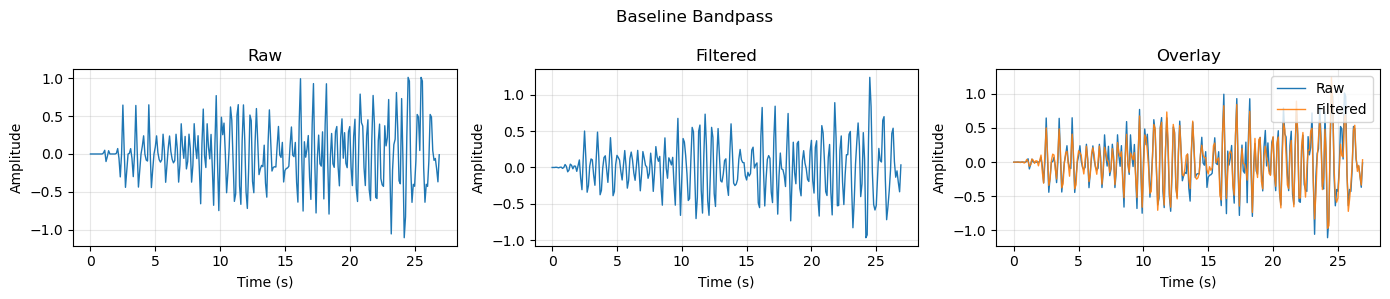

=== Estimated HR by spectral peak within [0.8, 3.0] Hz (BPM) ===
Baseline Bandpass               : 113.33


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import savgol_filter, stft, istft, iirnotch, butter, filtfilt
from scipy.signal import hilbert

# ===== 公用工具（中文註解）=====
def bandpass(sig, fs, lo=0.8, hi=3.0, order=4): # 帶通濾波：心跳頻段 (0.8–3.0 Hz)
    # 帶通濾波：心跳頻段 (0.8–3.0 Hz)
    ny = 0.5*fs
    b, a = butter(order, [lo/ny, hi/ny], btype='band')
    return filtfilt(b, a, sig)

def notch_at(sig, fs, f0, Q=30): # 陷波：抑制呼吸基頻與其諧波
    # 陷波：抑制呼吸基頻與其諧波
    if f0 <= 0 or f0 >= fs/2:
        return sig
    b, a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b, a, sig)

def peak_hr_bpm(x, fs, lo=0.8, hi=3.0):  # 頻域主峰估 HR（粗略）
    # 頻域主峰估 HR（粗略）
    n = len(x)
    f = np.fft.rfftfreq(n, 1/fs)
    X = np.abs(np.fft.rfft(x))
    band = (f>=lo) & (f<=hi)
    if not np.any(band):
        return np.nan
    idx = np.argmax(X[band])
    f_pk = f[band][idx]
    return f_pk*60.0

def agc_rms(x, fs, target_rms=0.6, attack_ms=30, release_ms=200, eps=1e-12):
    # 自動增益控制：讓振幅看起來一致（可選）
    a = np.exp(-1.0/(fs*attack_ms/1000.0))
    r = np.exp(-1.0/(fs*release_ms/1000.0))
    y = np.zeros_like(x, dtype=float)
    env = 0.0
    for i, xi in enumerate(x):
        e2 = xi*xi
        if e2 > env:
            env = a*env + (1-a)*e2
        else:
            env = r*env + (1-r)*e2
        g = target_rms/(np.sqrt(env)+eps)
        y[i] = xi*g
    return y

def envelope_norm(x, q=0.8, eps=1e-12):
    # 以 Hilbert 包絡做分位數正規化（可選，避免尖峰主導）
    env = np.abs(hilbert(x))
    scale = np.quantile(env, q)+eps
    return x/scale

def plot_triplet(t, x_raw, x_filt, title, overlay_alpha=0.9, ylims=None):
    # 三聯圖：Raw / Filtered / Overlay（全英文抬頭）
    fig, axes = plt.subplots(1, 3, figsize=(14, 3), sharex=True)
    axes[0].plot(t, x_raw, linewidth=1)
    axes[0].set_title("Raw")
    axes[1].plot(t, x_filt, linewidth=1)
    axes[1].set_title("Filtered")
    axes[2].plot(t, x_raw, linewidth=1, label="Raw")
    axes[2].plot(t, x_filt, linewidth=1, alpha=overlay_alpha, label="Filtered")
    axes[2].set_title("Overlay"); axes[2].legend(loc="upper right")
    for ax in axes:
        ax.grid(True, alpha=0.3)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amplitude")
        if ylims is not None:
            ax.set_ylim(ylims)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    return pd.DataFrame({"t_sec":t,"wave":x_filt})

# ===== 方法實作（中文註解）=====
def method_bandpass(x, fs):
    # 基礎帶通
    return bandpass(x, fs, 0.8, 3.0)

def method_bp_notch(x, fs, rr_bpm):
    # 帶通 + 在呼吸與二次諧波處陷波
    y = bandpass(x, fs, 0.8, 3.0)
    rr_hz = rr_bpm/60.0
    y = notch_at(y, fs, rr_hz, Q=35)
    y = notch_at(y, fs, 2*rr_hz, Q=35)
    return y

def method_sg_bp(x, fs, win_sec=0.5, poly=3):
    # Savitzky–Golay 平滑 + 帶通
    win = int(max(5, np.floor(win_sec*fs)//2*2+1))  # 強制奇數
    y = savgol_filter(x, window_length=win, polyorder=poly, mode='interp')
    y = bandpass(y, fs, 0.8, 3.0)
    return y

def method_ssa_band_select(x, fs, embed=200, rank_max=12, lo=0.8, hi=3.0):
    # SSA：Hankel->SVD->重建前r成分->只保留主頻落在心跳帶的成分
    N = len(x)
    L = int(min(embed, N//2))
    K = N - L + 1
    X = np.column_stack([x[i:i+L] for i in range(K)])
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    r = min(rank_max, len(s))
    comps = []
    for i in range(r):
        Hi = np.outer(U[:, i]*s[i], Vt[i, :])
        y = np.zeros(N); cnt = np.zeros(N)
        for d in range(-L+1, K):
            diag_vals = np.diag(Hi, k=d)
            idxs = np.arange(max(0, -d), min(L, K-d)) + max(0, d)
            y[idxs] += diag_vals; cnt[idxs] += 1
        comps.append(y/(cnt+1e-12))
    sel = np.zeros(N)
    for y in comps:
        hr = peak_hr_bpm(y, fs, lo, hi)
        if np.isfinite(hr):
            sel += y
    return bandpass(sel, fs, lo, hi)

def method_specsub_bp(x, fs, nperseg=256, noverlap=192, alpha=1.0, floor=0.1):
    # STFT 譜減 + 帶通
    f, t, Z = stft(x, fs=fs, nperseg=nperseg, noverlap=noverlap, boundary=None)
    mag = np.abs(Z); ph = np.angle(Z)
    noise = np.median(mag, axis=1, keepdims=True)
    mag_hat = np.maximum(mag - alpha*noise, floor*noise)
    Z_hat = mag_hat * np.exp(1j*ph)
    y = istft(Z_hat, fs=fs, nperseg=nperseg, noverlap=noverlap, boundary=None)[1]
    y = y[:len(x)]
    return bandpass(y, fs, 0.8, 3.0)

def method_ale(x, fs, D=6, M=14, mu=0.01):
    # 自適應線性增強器（LMS）
    N = len(x); w = np.zeros(M); y = np.zeros(N)
    ref = np.zeros(N); ref[D:] = x[:-D]
    for n in range(M, N):
        u = ref[n-M:n][::-1]
        y[n] = np.dot(w, u)
        e = x[n] - y[n]
        w += 2*mu*e*u
    return bandpass(y, fs, 0.8, 3.0)

# ===== Kalman 濾波（中文註解）=====
def kalman_1d(x, q_scale=1e-4, r_scale=1e-2, smooth=True):
    """
    一維卡爾曼：狀態 x_k = x_{k-1} + w_k，量測 z_k = x_k + v_k
    Q = q_scale*var(x), R = r_scale*var(x)
    smooth=True 時回傳 RTS 平滑結果，否則回傳前向濾波
    """
    x = np.asarray(x, dtype=float)
    N = len(x)
    if N == 0:
        return x

    var = np.var(x) + 1e-12
    Q = q_scale * var
    R = r_scale * var

    # 前向濾波
    x_pred = np.zeros(N)
    P_pred = np.zeros(N)
    x_filt = np.zeros(N)
    P_filt = np.zeros(N)

    # 初始化
    x_filt[0] = x[0]
    P_filt[0] = var

    for k in range(1, N):
        # predict
        x_pred[k] = x_filt[k-1]
        P_pred[k] = P_filt[k-1] + Q
        # update
        K = P_pred[k] / (P_pred[k] + R)
        x_filt[k] = x_pred[k] + K * (x[k] - x_pred[k])
        P_filt[k] = (1 - K) * P_pred[k]

    if not smooth:
        return x_filt

    # RTS 平滑
    x_smooth = np.copy(x_filt)
    P_smooth = np.copy(P_filt)
    for k in range(N-2, -1, -1):
        C = P_filt[k] / (P_pred[k+1] + 1e-12)
        x_smooth[k] = x_filt[k] + C * (x_smooth[k+1] - x_pred[k+1])
        P_smooth[k] = P_filt[k] + C**2 * (P_smooth[k+1] - P_pred[k+1])
    return x_smooth

def method_kalman_then_bp(x, fs, q_scale=1e-4, r_scale=1e-2, smooth=True):
    # 先卡爾曼平滑原始訊號，再帶通到心跳帶
    xd = signal.detrend(x, type="linear")
    xk = kalman_1d(xd, q_scale=q_scale, r_scale=r_scale, smooth=smooth)
    return bandpass(xk, fs, 0.8, 3.0)

def method_bp_then_kalman(x, fs, q_scale=5e-5, r_scale=5e-3, smooth=True):
    # 先帶通聚焦心跳，再用卡爾曼去除殘餘雜訊與波紋
    y = bandpass(x, fs, 0.8, 3.0)
    yk = kalman_1d(y, q_scale=q_scale, r_scale=r_scale, smooth=smooth)
    return yk

# ===== 取資料 =====
# 假設你已建立 summary（含 dataframe: t_sec/heartbeat, fs_Hz）
df = summary['dataframe']
t  = df['t_sec'].to_numpy()
x  = df['heartbeat'].to_numpy().astype(float)
fs = float(summary['fs_Hz'])

# ===== 實驗設定（中文註解）=====
rr_bpm_for_notch = 14.0         # 若知道呼吸率，填於此（合成資料可直接用）
use_agc = False                  # 是否啟用AGC讓振幅統一
use_env_norm = False            # 或選用包絡正規化
fixed_ylim = None               # 設成例如 (-3, 3) 可固定三圖y軸一致

methods = [
    ("Baseline Bandpass",              method_bandpass,        dict()),
    ("BP + Notch @ rr & 2rr",          method_bp_notch,        dict(rr_bpm=rr_bpm_for_notch)),
    ("Savitzky–Golay + BP",            method_sg_bp,           dict(win_sec=0.5, poly=3)),
    ("SSA Band-Selected + BP",         method_ssa_band_select, dict(embed=200, rank_max=12, lo=0.8, hi=3.0)),
    ("STFT Spectral Subtraction + BP", method_specsub_bp,      dict(nperseg=256, noverlap=192, alpha=1.0, floor=0.1)),
    ("ALE Adaptive Enhancer + BP",     method_ale,             dict(D=6, M=14, mu=0.01)),
    ("Kalman → Bandpass",              method_kalman_then_bp,  dict(q_scale=1e-4, r_scale=1e-2, smooth=True)),
    ("Bandpass → Kalman",              method_bp_then_kalman,  dict(q_scale=5e-5, r_scale=5e-3, smooth=True)),
]


# ===== 逐法顯示（圖表抬頭英文，註解中文）=====
for name, fn, kw in methods:
    y = fn(x, fs, **kw)
    if use_agc:
        # 先 RMS 型 AGC，再做輕度包絡正規（可選）
        y = agc_rms(y, fs, target_rms=0.6, attack_ms=30, release_ms=200)
    if use_env_norm:
        y = envelope_norm(y, q=0.8)
    filter_db=plot_triplet(t, x, y, title=name, ylims=fixed_ylim)
    break

# ===== HR 粗估（英文輸出，便於對照）=====
print("=== Estimated HR by spectral peak within [0.8, 3.0] Hz (BPM) ===")
for name, fn, kw in methods:
    y = fn(x, fs, **kw)
    if use_agc:
        y = agc_rms(y, fs, target_rms=0.6, attack_ms=30, release_ms=200)
    if use_env_norm:
        y = envelope_norm(y, q=0.8)
    est = peak_hr_bpm(y, fs)
    print(f"{name:32s}: {est:6.2f}")
    break



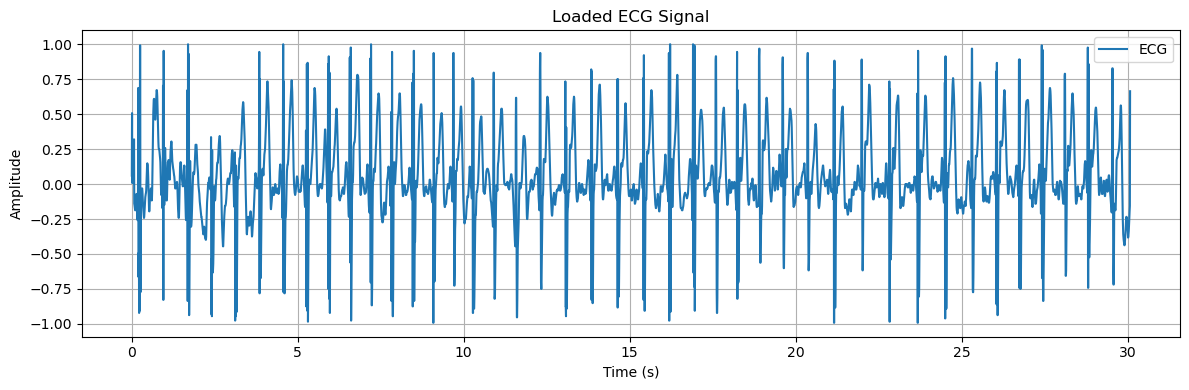

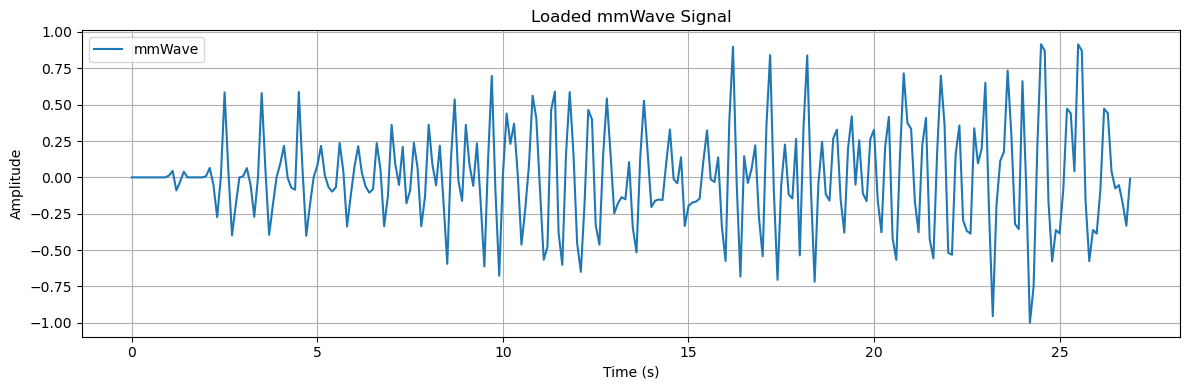

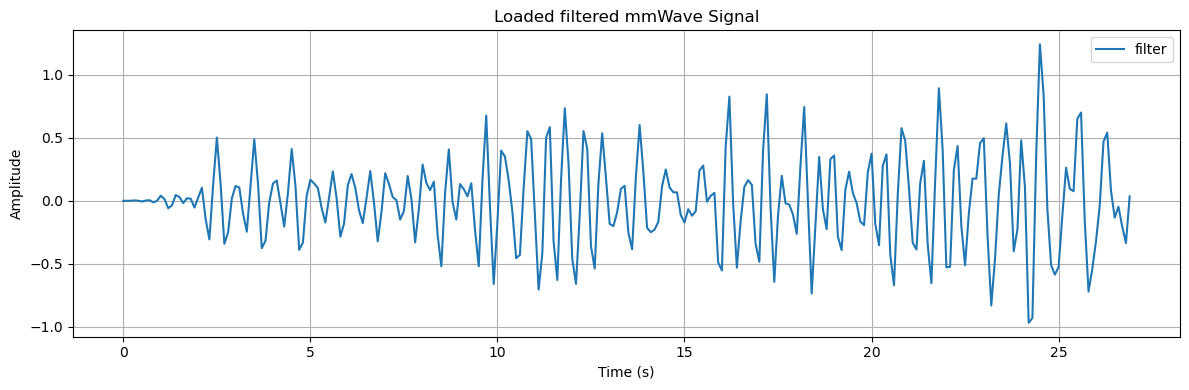

In [21]:
df_ecg_fixed = normalize_ts(df_ecg, y_candidates=('wave',), dt=None)
pltot_fixed(df_ecg_fixed, title='Loaded ECG Signal', label='ECG')
df_mmv_fixed = normalize_ts(df_mmv, y_candidates=('mmv','mmwave','heartbeat','value','signal'), dt=0.1)
pltot_fixed(df_mmv_fixed, title='Loaded mmWave Signal', label='mmWave')
pltot_fixed(filter_db,title='Loaded filtered mmWave Signal', label='filter')

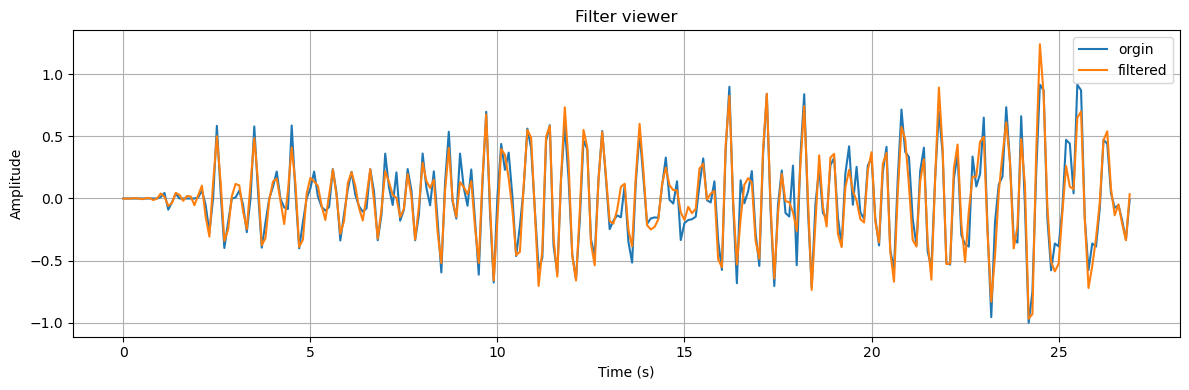

In [24]:
combine_plots(df_mmv_fixed,filter_db,'Filter viewer','orgin','filtered')

# 重建心律波

In [25]:

def analyze_cepstrum(summary,
                     save_plots=True,
                     outdir=None,
                     hr_range_bpm=(40, 200),
                     lifter_q_sec=0.10,
                     win_sec=10.0,
                     hop_sec=0.5,
                     eps=1e-12):
    df = summary['dataframe']
    t_sec = df['t_sec'].values
    x = df['heartbeat'].values.astype(float)
    fs = float(summary['fs_Hz'])
    if outdir is None:
        outdir = summary.get('csv', 'outputs').replace('heart_rate_series.csv', '').rstrip('/')

    N = len(x)
    hr_lo, hr_hi = hr_range_bpm
    q_lo = 60.0 / hr_hi
    q_hi = 60.0 / hr_lo

    # ---------- 全段倒頻譜（使用 N 長度窗，nfft 取 >= N 的 2 次方） ----------
    nfft_global = int(2 ** np.ceil(np.log2(max(16, N))))
    w_glob = signal.windows.hann(N, sym=False)
    Xg = np.fft.rfft(x * w_glob, n=nfft_global)
    Lg = np.log(np.maximum(np.abs(Xg), eps))
    c_global = np.real(np.fft.irfft(Lg, n=nfft_global))
    q_axis_g = np.arange(nfft_global) / fs

    # liftering 與 HR 搜尋窗
    c_glift = c_global.copy()
    c_glift[q_axis_g < lifter_q_sec] = 0.0
    mask_hr_q_g = (q_axis_g >= max(q_lo, lifter_q_sec)) & (q_axis_g <= q_hi)
    q_star_global = q_axis_g[mask_hr_q_g][np.argmax(c_glift[mask_hr_q_g])]
    hr_global = 60.0 / q_star_global

    # ---------- 滑動窗參數（不超過訊號長度） ----------
    win_len = int(round(win_sec * fs))
    hop_len = int(round(hop_sec * fs))
    if win_len > N:
        win_len = N
    if hop_len < 1:
        hop_len = 1
    if win_len < 4:
        raise ValueError("win_sec too short given fs and signal length.")

    nfft_win = int(2 ** np.ceil(np.log2(max(16, win_len))))
    q_axis_w = np.arange(nfft_win) / fs
    mask_hr_q_w = (q_axis_w >= max(q_lo, lifter_q_sec)) & (q_axis_w <= q_hi)

    # ---------- 逐窗 cepstrogram 與 HR 軌跡 ----------
    w = signal.windows.hann(win_len, sym=False)
    centers, q_peaks, hr_track, conf_psr, frames = [], [], [], [], []

    for start in range(0, max(1, N - win_len + 1), hop_len):
        seg = x[start:start + win_len]
        if len(seg) < win_len:
            break
        Xw = np.fft.rfft(seg * w, n=nfft_win)
        Lw = np.log(np.maximum(np.abs(Xw), eps))
        c = np.real(np.fft.irfft(Lw, n=nfft_win))

        # liftering
        c[q_axis_w < lifter_q_sec] = 0.0

        # HR 對應 quefrency 主峰
        c_hr = np.where(mask_hr_q_w, c, 0.0)
        pk_idx = int(np.argmax(c_hr))
        q_pk = q_axis_w[pk_idx]
        hr = 60.0 / q_pk

        # PSR（主峰對旁瓣比）
        sl_mask = mask_hr_q_w.copy()
        win_ex = 2
        sl_mask[max(0, pk_idx - win_ex):min(len(sl_mask), pk_idx + win_ex + 1)] = False
        sidelobe = np.mean(c[sl_mask]) if np.any(sl_mask) else 0.0
        psr = (c[pk_idx] / (sidelobe + 1e-9)) if sidelobe > 0 else np.inf

        centers.append(t_sec[min(start + win_len // 2, N - 1)])
        q_peaks.append(q_pk)
        hr_track.append(hr)
        conf_psr.append(psr)
        frames.append(c)

    centers = np.asarray(centers)
    q_peaks = np.asarray(q_peaks)
    hr_track = np.asarray(hr_track)
    conf_psr = np.asarray(conf_psr)
    cepstrogram = np.stack(frames, axis=1) if len(frames) else np.zeros((nfft_win, 0))

    # ---------- 視覺化 ----------
    print("=" * 60)
    print("Cepstrum Analysis")
    print("=" * 60)
    print(f"Global HR estimate from cepstrum: {hr_global:.1f} bpm")
    if len(hr_track):
        print(f"Track HR: mean={np.nanmean(hr_track):.1f} bpm, std={np.nanstd(hr_track):.1f} bpm")
    print(f"Quefrency search window: [{q_lo:.3f}, {q_hi:.3f}] s  (HR {hr_lo}-{hr_hi} bpm)")
    print(f"Liftering: q < {lifter_q_sec:.3f} s set to 0")

    # 全段
    plt.figure(figsize=(10, 4))
    plt.plot(q_axis_g, c_global, label="Cepstrum (global)")
    plt.axvspan(0, lifter_q_sec, alpha=0.15, label="liftered")
    plt.axvline(q_star_global, linestyle='--', label=f'Peak={q_star_global:.3f}s ({hr_global:.1f} bpm)')
    plt.xlim(0, min(2.0, q_hi * 1.2))
    plt.xlabel("Quefrency (s)"); plt.ylabel("Amplitude"); plt.title("Global Real Cepstrum")
    plt.legend(); plt.tight_layout()
    if save_plots: plt.savefig(f"{outdir}/cepstrum_global.png", dpi=200)
    plt.show()

    # cepstrogram
    if cepstrogram.shape[1] > 0:
        q_max_plot = min(2.0, q_hi * 1.2)
        q_mask_plot = q_axis_w <= q_max_plot
        C_db = 10 * np.log10(np.maximum(cepstrogram[q_mask_plot, :], eps))
        plt.figure(figsize=(12, 5))
        im = plt.pcolormesh(centers, q_axis_w[q_mask_plot], C_db, shading='gouraud')
        plt.colorbar(im, label='Cepstrum Power (dB)')
        plt.xlabel("Time (s)"); plt.ylabel("Quefrency (s)"); plt.title("Cepstrogram")
        plt.tight_layout()
        if save_plots: plt.savefig(f"{outdir}/cepstrogram.png", dpi=200)
        plt.show()

        plt.figure(figsize=(12, 4))
        plt.plot(centers, hr_track, linewidth=1.5, label="HR from cepstrum")
        if summary.get('est_hr_bpm') and np.isfinite(summary['est_hr_bpm']):
            plt.axhline(summary['est_hr_bpm'], linestyle='--',
                        label=f"Est. HR (summary) {summary['est_hr_bpm']:.1f} bpm")
        plt.xlabel("Time (s)"); plt.ylabel("HR (bpm)"); plt.title("HR Track from Cepstrum Peaks")
        plt.legend(); plt.tight_layout()
        if save_plots: plt.savefig(f"{outdir}/hr_track_cepstrum.png", dpi=200)
        plt.show()

        plt.figure(figsize=(12, 3))
        plt.plot(centers, conf_psr, linewidth=1.2)
        plt.xlabel("Time (s)"); plt.ylabel("PSR"); plt.title("Peak-to-Sidelobe Ratio")
        plt.tight_layout()
        if save_plots: plt.savefig(f"{outdir}/cepstrum_confidence_psr.png", dpi=200)
        plt.show()

    return {
        "q_axis_global_sec": q_axis_g,
        "cepstrum_global": c_global,
        "q_star_global_sec": float(q_star_global),
        "hr_global_bpm": float(hr_global),
        "q_axis_win_sec": q_axis_w,
        "centers_sec": centers,
        "cepstrogram": cepstrogram,
        "q_peak_track_sec": q_peaks,
        "hr_track_bpm": hr_track,
        "confidence_psr": conf_psr,
        "params": {
            "fs_Hz": fs, "win_sec": win_sec, "hop_sec": hop_sec,
            "hr_range_bpm": hr_range_bpm, "lifter_q_sec": lifter_q_sec,
            "nfft_global": nfft_global, "nfft_win": nfft_win
        }
    }


In [ ]:
import numpy as np
from scipy import signal, interpolate
import matplotlib.pyplot as plt

def reconstruct_heartbeat_from_cepstrum(
    summary, cep_results,
    peak_search_halfwin=0.25,      # 縮小搜索窗口，更精確定位
    template_win=0.5,
    show_plots=True,
    ibi_min=0.25,      # 0.25 s ≈ 240 bpm (更高上限)
    ibi_max=1.50,      # 1.50 s ≈ 40  bpm (更低下限)
    max_iter_factor=15, # 增加迭代上限
    interpolation_smoothing=1,  # IBI軌跡平滑參數
    peak_prominence=0.5  # 峰值顯著性閾值
):
    """
    更靈敏的心跳重建，優化參數以減少漏檢：
      - 縮小峰值搜索窗口 (0.45→0.25s)
      - 擴大生理範圍 (240-40 bpm)
      - 添加峰值顯著性檢測
      - IBI軌跡平滑處理
      - 更積極的異常值過濾
    """
    # -------- inputs --------
    df = summary['dataframe']
    t  = df['t_sec'].values
    y  = df['heartbeat'].values.astype(float)
    fs = float(summary['fs_Hz'])

    centers = np.asarray(cep_results["centers_sec"])
    q_pk    = np.asarray(cep_results["q_peak_track_sec"])

    if centers.size == 0 or q_pk.size == 0:
        raise ValueError("No cepstrum track. Run analyze_cepstrum first.")

    # -------- sanitize cepstrum track --------
    ord_idx = np.argsort(centers)
    centers = centers[ord_idx]
    q_pk    = q_pk[ord_idx]

    m = np.isfinite(centers) & np.isfinite(q_pk)
    centers, q_pk = centers[m], q_pk[m]
    if centers.size == 0:
        raise ValueError("Empty/invalid cepstrum track after sanitization.")

    # 更積極地過濾異常IBI值
    q_median = np.median(q_pk)
    q_std = np.std(q_pk)
    outlier_mask = np.abs(q_pk - q_median) < 2.5 * q_std  # 2.5σ範圍
    centers, q_pk = centers[outlier_mask], q_pk[outlier_mask]

    # clamp to wider physiologic range
    q_pk = np.clip(q_pk, ibi_min, ibi_max)

    # 平滑IBI軌跡（使用移動平均）
    if len(q_pk) >= interpolation_smoothing:
        from scipy.ndimage import uniform_filter1d
        q_pk_smooth = uniform_filter1d(q_pk, size=interpolation_smoothing, mode='nearest')
    else:
        q_pk_smooth = q_pk

    # cubic spline interpolation for smoother tracking
    try:
        from scipy.interpolate import UnivariateSpline
        ibi_f = UnivariateSpline(centers, q_pk_smooth, s=0.01, k=min(3, len(centers)-1))
    except:
        ibi_f = interpolate.interp1d(
            centers, q_pk_smooth, kind="linear",
            bounds_error=False, fill_value=(q_pk_smooth[0], q_pk_smooth[-1])
        )

    # -------- build beat timeline (adaptive step) --------
    beats = [centers[0]]
    t_cur = centers[0]
    max_iter = int(max_iter_factor * (t[-1] - t[0]) / max(ibi_min, 1e-6)) + 2000
    iters = 0
    
    while t_cur < t[-1] - 0.2:  # 減少邊界裕度
        step = float(ibi_f(t_cur))
        if not np.isfinite(step) or step < ibi_min:
            step = ibi_min
        elif step > ibi_max:
            step = ibi_max
        t_cur += step
        beats.append(t_cur)
        iters += 1
        if iters > max_iter:
            raise RuntimeError("Beat-building loop exceeded cap (forward).")

    # backward
    t_cur = centers[0]
    iters = 0
    left = []
    while t_cur > t[0] + 0.2:
        step = float(ibi_f(t_cur))
        if not np.isfinite(step) or step < ibi_min:
            step = ibi_min
        elif step > ibi_max:
            step = ibi_max
        t_cur -= step
        left.append(t_cur)
        iters += 1
        if iters > max_iter:
            raise RuntimeError("Beat-building loop exceeded cap (backward).")

    beats = np.array(sorted(left[::-1] + beats))

    # -------- 增強的峰值檢測 --------
    half_samp = max(1, int(round(peak_search_halfwin * fs)))
    adj_beats = []
    
    for tb in beats:
        i  = int(np.searchsorted(t, tb))
        i0 = max(0, i - half_samp)
        i1 = min(len(y)-1, i + half_samp)
        if i1 <= i0 + 2:
            continue
        
        # 在窗口內尋找峰值
        window = y[i0:i1+1]
        
        # 使用 scipy 的 find_peaks 提高準確性
        peaks, properties = signal.find_peaks(
            window, 
            prominence=peak_prominence * np.std(window),
            distance=int(0.15 * fs)  # 最小峰值間距（避免雙重檢測）
        )
        
        if len(peaks) > 0:
            # 選擇最高的峰值
            best_peak = peaks[np.argmax(window[peaks])]
            loc = i0 + best_peak
        else:
            # 回退到簡單最大值
            loc = i0 + np.argmax(window)
        
        adj_beats.append(t[loc])
    
    adj_beats = np.asarray(adj_beats)
    
    # 移除過近的重複檢測
    if len(adj_beats) > 1:
        diffs = np.diff(adj_beats)
        keep_mask = np.concatenate([[True], diffs > ibi_min * 0.8])
        adj_beats = adj_beats[keep_mask]

    if adj_beats.size < 3:
        raise ValueError("Too few refined beats. Consider adjusting parameters.")

    # -------- CSA template --------
    L = int(round(template_win * fs))
    L = max(L, 3)
    halfL = L // 2

    segs, idx_keep = [], []
    for tb in adj_beats:
        i  = int(np.searchsorted(t, tb))
        i0 = i - halfL
        i1 = i - halfL + L
        if i0 < 0 or i1 > len(y):
            continue
        segs.append(y[i0:i1])
        idx_keep.append(i)

    if not segs:
        raise ValueError("No valid segments for CSA.")
    
    segs = np.stack(segs, axis=0)
    template = np.median(segs, axis=0)

    # -------- OLA with normalization --------
    y_rec = np.zeros_like(y, float)
    w_ov  = signal.windows.hann(L, sym=False)
    w_sum = np.zeros_like(y, float)
    for i in idx_keep:
        i0 = i - halfL
        i1 = i - halfL + L
        y_rec[i0:i1] += template * w_ov
        w_sum[i0:i1] += w_ov
    y_rec /= np.maximum(w_sum, 1e-12)

    # -------- compute IBI/HR --------
    adj_beats_sorted = np.sort(adj_beats)
    ibi = np.diff(adj_beats_sorted)
    valid = (ibi >= ibi_min) & (ibi <= ibi_max)
    ibi = ibi[valid]
    hr_inst = 60.0 / np.clip(ibi, 1e-6, None)

    # 計算平均心率和統計
    hr_mean = np.mean(hr_inst) if len(hr_inst) > 0 else 0
    hr_std = np.std(hr_inst) if len(hr_inst) > 0 else 0

    # -------- plots --------
    if show_plots:
        z  = (y - y.mean())/(y.std() + 1e-12)
        zr = (y_rec - y.mean())/(y.std() + 1e-12)

        fig, axes = plt.subplots(2, 1, figsize=(14, 7))
        
        # 主波形圖
        N = len(t)
        step = max(1, N // 20000)
        axes[0].plot(t[::step], z[::step],  lw=0.8, alpha=0.7, label="Input (z)")
        axes[0].plot(t[::step], zr[::step], lw=1.2, label="Reconstructed (z)")
        
        mk_step = max(1, len(adj_beats_sorted)//1000)
        mk_times = adj_beats_sorted[::mk_step]
        if mk_times.size:
            axes[0].scatter(mk_times, np.interp(mk_times, t, z), 
                          s=15, alpha=0.8, c='red', label="Beats")
        
        axes[0].set_xlabel("Time (s)")
        axes[0].set_ylabel("Amplitude (z)")
        axes[0].set_title(f"Heartbeat Reconstruction | Mean HR: {hr_mean:.1f}±{hr_std:.1f} bpm | Beats: {len(adj_beats_sorted)}")
        axes[0].grid(True, alpha=0.3)
        axes[0].legend()
        
        # 瞬時心率圖
        if len(hr_inst) > 0:
            beat_centers = (adj_beats_sorted[:-1] + adj_beats_sorted[1:]) / 2
            beat_centers = beat_centers[valid]
            axes[1].plot(beat_centers, hr_inst, 'o-', lw=1.5, markersize=4, alpha=0.7)
            axes[1].axhline(hr_mean, color='red', linestyle='--', alpha=0.7, label=f'Mean: {hr_mean:.1f} bpm')
            axes[1].fill_between(beat_centers, hr_mean-hr_std, hr_mean+hr_std, 
                               alpha=0.2, color='red', label=f'±1 SD')
            axes[1].set_xlabel("Time (s)")
            axes[1].set_ylabel("Heart Rate (bpm)")
            axes[1].set_title("Instantaneous Heart Rate")
            axes[1].grid(True, alpha=0.3)
            axes[1].legend()
        
        plt.tight_layout()
        plt.show()

        # 模板圖
        plt.figure(figsize=(8, 3))
        tt = np.arange(L)/fs - (halfL/fs)
        plt.plot(tt, template, lw=1.5)
        plt.xlabel("Time around beat (s)")
        plt.ylabel("Amplitude")
        plt.title("Beat Template (median)")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # -------- outputs --------
    return {
        "beat_times_sec": adj_beats_sorted,
        "ibi_sec": ibi,
        "hr_inst_bpm": hr_inst,
        "hr_mean_bpm": hr_mean,
        "hr_std_bpm": hr_std,
        "num_beats": len(adj_beats_sorted),
        "template": template,
        "template_time_sec": (np.arange(L)/fs - (halfL/fs)),
        "reconstructed": y_rec
    }


def plot_reconstructed_only(summary, rec, normalize=True):
    t = summary['dataframe']['t_sec'].values
    y = rec['reconstructed'].astype(float)
    if normalize:
        base = summary['dataframe']['heartbeat'].values
        y = (y - base.mean())/(base.std()+1e-12)
    
    plt.figure(figsize=(14, 5))
    plt.plot(t, y, lw=1.2)
    
    # 標記心跳位置
    beats = rec['beat_times_sec']
    plt.scatter(beats, np.interp(beats, t, y), 
               s=20, c='red', alpha=0.6, zorder=5, label='Beats')
    
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude" + (" (z)" if normalize else ""))
    plt.title(f"Reconstructed Heartbeat | HR: {rec['hr_mean_bpm']:.1f}±{rec['hr_std_bpm']:.1f} bpm | {rec['num_beats']} beats")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# 使用範例（更靈敏的配置）
res={'name':main}

print(f"\n{'='*60}")
print(f"Method: {res['name']}, Initial Estimated HR: {res['est_hr_bpm']:.1f} bpm")

cep = analyze_cepstrum(res)
rec = reconstruct_heartbeat_from_cepstrum(
    res, cep, 
    show_plots=True,
    peak_search_halfwin=0.25,  # 更小的搜索窗口
    ibi_min=0.25,              # 支持更高心率
    peak_prominence=0.25        # 降低峰值閾值以提高靈敏度
)

print(f"Reconstructed HR: {rec['hr_mean_bpm']:.1f}±{rec['hr_std_bpm']:.1f} bpm")
print(f"Number of beats detected: {rec['num_beats']}")
print(f"Instantaneous HR range: {rec['hr_inst_bpm'].min():.1f}-{rec['hr_inst_bpm'].max():.1f} bpm")

plot_reconstructed_only(summary, rec, normalize=True)



NameError: name 'collect_filter_results' is not defined